In [67]:
!pip install catboost

In [68]:
import pandas as pd
import pyarrow.parquet as pq

In [69]:
df = pd.read_parquet('/content/drive/MyDrive/processed.parquet')
product_df = df[["id", "monthly_charge", "churn"]]
df.drop("id", axis=1, inplace=True)

<ipython-input-122-239c49704ee0>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sizes = [churn_counts[0], churn_counts[1]]


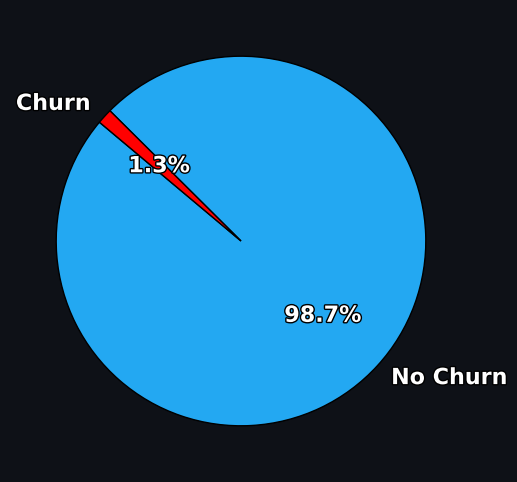

In [122]:
churn_counts = df["churn"].value_counts()
labels = ["No Churn", "Churn"]
sizes = [churn_counts[0], churn_counts[1]]
colors = ["#23a8f2", "red"]  # Beautiful contrasting colors
import matplotlib.patheffects as path_effects

# Create pie chart with black background and outlined text
fig, ax = plt.subplots(figsize=(6, 6), facecolor='#0e1117')

# Plot pie chart
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 16, 'weight': 'bold', 'color': 'white'}
)

# Add black outline to text elements
for text in texts + autotexts:
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])

# Set title with white color
# ax.set_title("Churn Distribution", fontsize=20, weight='bold', color='white')

# Show chart
plt.show()


In [58]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, roc_auc_score
import numpy as np

# Özellikleri ve hedef değişkeni ayırma
X = df.drop(columns=['churn'])  # churn dışındaki tüm sütunlar özellik
y = df['churn']  # Hedef değişken

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Compute the positive class weight
pos_class_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)

# Initialize XGBClassifier with scale_pos_weight and max_delta_step
model = XGBClassifier(
    n_estimators=100,
    objective='binary:logistic',
    scale_pos_weight=pos_class_weight,
    max_delta_step=1,
    random_state=42
)

# Fit the model on original training data
model.fit(X_train, y_train)

# Generate predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"F1 Score:   {f1:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"AUC:        {auc:.4f}")

F1 Score:   0.0616
Recall:     0.8076
Precision:  0.0320
AUC:        0.7976


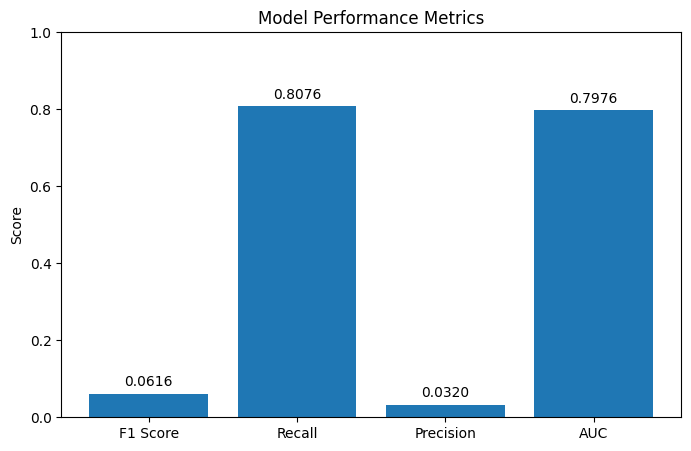

In [123]:
import matplotlib.pyplot as plt

# Data
metrics = ["F1 Score", "Recall", "Precision", "AUC"]
values = [0.0616, 0.8076, 0.0320, 0.7976]

# Create bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values)

# Labels and title
plt.ylabel("Score")
plt.title("Model Performance Metrics")
plt.ylim(0, 1)

# Show values on top of bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')

# Show plot
plt.show()


In [59]:
# import joblib
# joblib.dump(model, "xgb_churn_model.pkl")

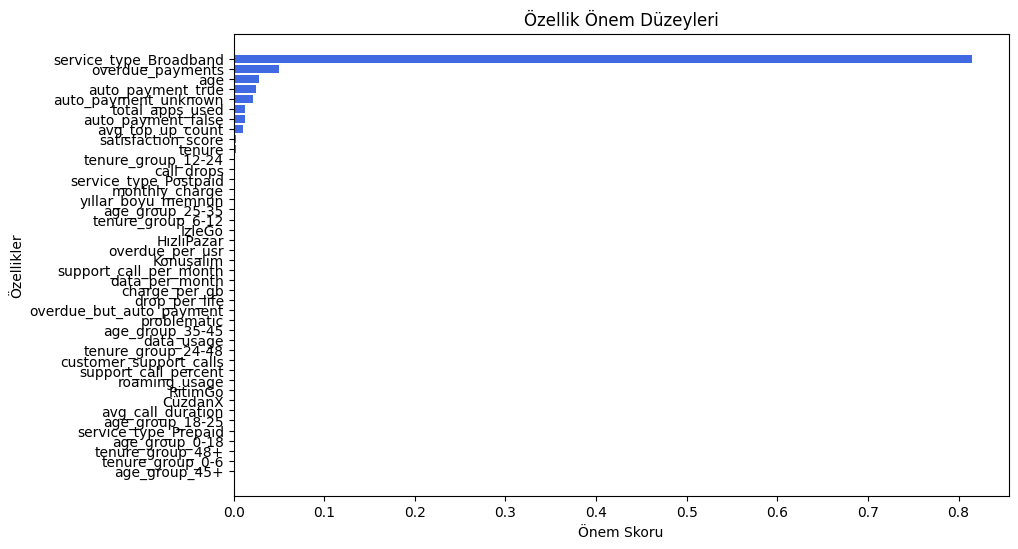

In [60]:
import matplotlib.pyplot as plt
import pandas as pd

# Özellik önem skorlarını al
feature_importances = model.feature_importances_

# Özellik isimlerini ve önem skorlarını bir DataFrame'e koy
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Önem sırasına göre sırala
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Görselleştirme
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='royalblue')
plt.xlabel('Önem Skoru')
plt.ylabel('Özellikler')
plt.title('Özellik Önem Düzeyleri')
plt.gca().invert_yaxis()  # En önemli özelliğin yukarıda olması için
plt.show()


In [63]:
# --- New Cell ---
# Assume that y_pred and y_pred_proba are already computed as in your previous cell.
# Also assume that X_test is a pandas DataFrame with its original index,
# and that you have a separate DataFrame 'product_df' which includes the columns 'id', 'monthly_charge', and 'churn'.
#
# For example, if you originally had a DataFrame 'df' with these columns, you might have defined:
# product_df = df[['id', 'monthly_charge', 'churn']]

# 1. Create a predictions DataFrame using the index from X_test
predictions_df = pd.DataFrame({
    'predicted_churn': y_pred,            # The binary churn predictions from the model
    'predicted_proba': y_proba         # The predicted probability for churn==True
}, index=X_test.index)

# 2. Filter for rows where the predicted churn is True
churn_true_df = predictions_df[predictions_df['predicted_churn'] == 1]

# 3. Sort the filtered rows by the predicted probability (highest first)
churn_true_df = churn_true_df.sort_values(by='predicted_proba', ascending=False)

# print("Churn==True predictions (without additional product info):")
# display(churn_true_df)

# 4. Merge with product_df to include id and monthly_charge.
# Here we assume that product_df has its index aligned with X_test.
# If not, you will need to ensure there is a common key to merge on.
merged_churn_df = product_df.loc[churn_true_df.index].copy()
merged_churn_df = merged_churn_df.join(churn_true_df)

# 5. Filter rows where monthly_charge is greater than the overall mean.
# If df is your original DataFrame, then:
mean_monthly_charge = df["monthly_charge"].mean()
filtered_merged_churn_df = merged_churn_df[merged_churn_df["monthly_charge"] > mean_monthly_charge]

print("Merged DataFrame with product info, predictions, and monthly_charge > mean:")
call_capacity = 100000
filtered_merged_churn_df = filtered_merged_churn_df.sort_values(by='monthly_charge', ascending=False)[:call_capacity]  ## PARAMETER 1
display(filtered_merged_churn_df)
filtered_merged_churn_df.to_csv("filtered_merged_churn_df.csv", index=False)

tp_count = filtered_merged_churn_df[filtered_merged_churn_df["churn"] == 1].shape[0]
fp_count = filtered_merged_churn_df[filtered_merged_churn_df["churn"] == 0].shape[0]

cost_per_call =  5 ## PARAMETER 2 AS COST PER CALL
call_cost_m = cost_per_call*100_000/1_000_000
total_churn_cost = filtered_merged_churn_df.loc[filtered_merged_churn_df["churn"] == 1, "monthly_charge"].sum()
savings_monthly = filtered_merged_churn_df.loc[filtered_merged_churn_df["churn"] == 1, "monthly_charge"].sum()
savings_monthly_m = round(savings_monthly/1_000_000, 3)

print(f"Doğru arama: {tp_count}, \nBoşa arama: {fp_count},\nKurtarılan aylık gelir:  {savings_monthly_m} Milyon TL / Ay\nArama masrafı: {call_cost_m} Milyon TL (Tek seferlik)")



Merged DataFrame with product info, predictions, and monthly_charge > mean:


,id,monthly_charge,churn,predicted_churn,predicted_proba
3718263,9abc9ce3-f824-4bfa-95e9-bd66d1c75c36,2499.99,False,1,0.614368
1477846,a7618add-f845-4ddf-8584-55ca2e372fb5,2499.99,False,1,0.665009
417725,18f0b2c0-ef29-400c-910e-51d1d8a95d70,2499.99,False,1,0.552000
959471,d576879e-2f55-4cf4-a42f-2255471637a4,2499.95,False,1,0.613732
7974482,1f1d1f92-b1a1-48e8-ad83-6d3cf418a934,2499.94,False,1,0.651181
...,...,...,...,...,...
6918478,475af07c-b5c3-461b-9196-cb8b636461c0,1826.08,False,1,0.628975
6083919,7095452d-bc84-49c9-a08c-472e22fc5d1b,1826.08,False,1,0.643091
8278231,77522d17-f91b-45ec-9d00-058fd3a86460,1826.07,False,1,0.592968
6155515,5a4fb9ce-7a2c-4b36-87e9-bca7fbfa585d,1826.07,False,1,0.614258


Doğru arama: 2562, 
Boşa arama: 97438,
Kurtarılan aylık gelir:  5.538 Milyon TL / Ay
Arama masrafı: 0.5 Milyon TL (Tek seferlik)
